In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

####Read in sample metadata and OTU table

In [32]:
%%R 
physeq = import_biom("data/otu_table_JSON_wtax.biom", "data/otusn_JSON.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/JSON_mapping_file.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("NTH", "PTH")) & (physeq.md$Month == "September"), physeq)
print(physeq)
physeq.md = sample_data(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]


In [16]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Till) # Making DeSeq Data set
dds = DESeq(dds) # Running 
dds
r = results(dds, cooksCutoff = FALSE, independentFiltering = TRUE, pAdjustMethod = "BH")

r

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
log2 fold change (MAP): Till P vs N 
Wald test p-value: Till P vs N 
DataFrame with 9756 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
OTU.7316  0.0000000             NA        NA        NA        NA        NA
OTU.9404  0.0000000             NA        NA        NA        NA        NA
OTU.5128  0.5059803       1.179728  1.991077 0.5925077 0.5535107        NA
OTU.10969 0.0000000             NA        NA        NA        NA        NA
OTU.10860 0.0000000             NA        NA        NA        NA        NA
...             ...            ...       ...       ...       ...       ...
OTU.5539  0.0000000             NA        NA        NA        NA        NA
OTU.11559 0.2208644    

In [18]:
%%R
r$OTU = rownames(r)
d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "pvalue", "padj")])
TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)
d = left_join(d, TT)
head(d)
df.l2fc = tbl_df(d)
head(df.l2fc)

Joining by: "OTU"
Source: local data frame [6 x 13]

        OTU log2FoldChange    lfcSE     pvalue padj    Rank1             Rank2
1  OTU.7316             NA       NA         NA   NA Bacteria __Armatimonadetes
2  OTU.9404             NA       NA         NA   NA Bacteria   __Acidobacteria
3  OTU.5128       1.179728 1.991077 0.55351068   NA Bacteria   __Acidobacteria
4 OTU.10969             NA       NA         NA   NA Bacteria   __Acidobacteria
5 OTU.10860             NA       NA         NA   NA Bacteria   __Acidobacteria
6   OTU.726      -4.238938 1.991627 0.03330565   NA Bacteria   __Acidobacteria
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), Rank8 (fctr)


In [66]:
%%R
write.table(df.l2fc, "data/l2fc_new.csv", row.names = FALSE, sep = ",")
df.l2fc

Source: local data frame [20,508 x 16]

   Month      OTU log2FoldChange     lfcSE    Rank1           Rank2  Rank3
1   July OTU.5128     1.78609925 0.9964620 Bacteria __Acidobacteria __S035
2   July  OTU.726    -1.64594993 0.6036527 Bacteria __Acidobacteria __S035
3   July  OTU.726    -1.64594993 0.6036527 Bacteria __Acidobacteria __S035
4   July OTU.1606     0.01579965 0.4005697 Bacteria __Acidobacteria __S035
5   July OTU.1606     0.01579965 0.4005697 Bacteria __Acidobacteria __S035
6   July OTU.1450    -0.96539558 0.5412362 Bacteria __Acidobacteria __S035
7   July OTU.1450    -0.96539558 0.5412362 Bacteria __Acidobacteria __S035
8   July OTU.3374     1.57432187 1.0429997 Bacteria __Acidobacteria __S035
9   July OTU.3321     1.10147809 1.0403108 Bacteria __Acidobacteria __S035
10  July OTU.1909    -0.94662891 0.8701928 Bacteria __Acidobacteria __S035
..   ...      ...            ...       ...      ...             ...    ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), Rank6 (fctr

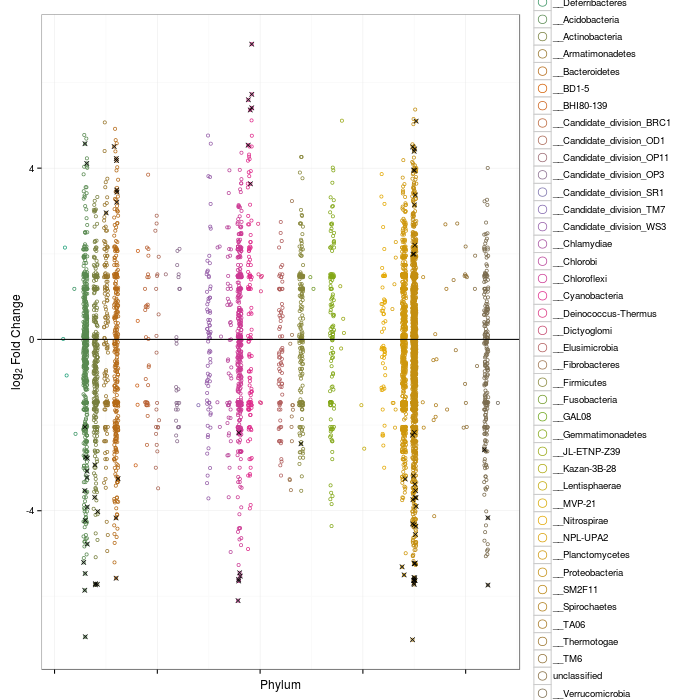

In [28]:
%%R -w 700 -h 700
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))


p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = 0)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [33]:
%%R
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2) 

In [36]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NTH responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PTH responder"

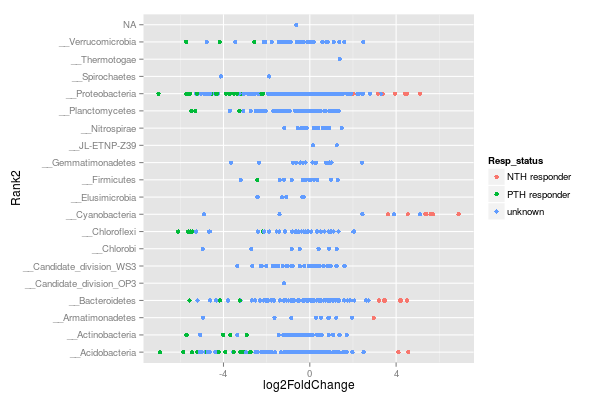

In [37]:
%%R -w 600 -h 400
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p